In [1]:
from our_utils import *
from noisy_causal_discovery import *

from cdt.data import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import laplace
from tqdm.notebook import tqdm

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
''' Load the dataset and the graph and convert to correct format and normalize the data.'''

raw_data, graph = load_dataset('sachs')
np_raw_data = np.array(raw_data).astype(float)

n_full, d = np_raw_data.shape # extract n, d

G = np.zeros((d,d)) # build graph

names_to_dim = {'praf':0, 'pmek':1, 'plcg':2, 'PIP2':3, 'PIP3':4, 'p44/42':5, 'pakts473':6, 'PKA':7, 'PKC':8, 'P38':9, 'pjnk':10}

for name_from, adj_dict in graph.adjacency():
    for name_to in adj_dict.keys():
        G[names_to_dim[name_from], names_to_dim[name_to]] = 1
        
data_full = np.zeros((n_full, d)) 
for j in range(d):  # normalize
    data_full[:, j] = (np_raw_data[:, j] - np.mean(np_raw_data[:, j])) / np.std(np_raw_data[:, j])
    
nr_edges = np.sum(G)

In [3]:
''' Choose general experiment parameters. '''

trials = 100          # no. of trials to average over
err_lvl = 0.05        # signficance level
delta = 0.5          # delta Huber parameter
no_graphs = 10        # number of graph variations
n = 100               # sample sized to be used in experiments
p_add = 5/(d*d)       # prob. of adding edge
p_remove = 5/nr_edges # prob. of removing edge

split_choices = [0.05, 0.5, 0.95] # splitting baselines

eps_choices = [0.005, 0.01, 0.02, 0.04, 0.08] # privacy parameters

split_shd, noisy_shd = {}, {}        # initialize the SHD results dictionaries
split_widths, noisy_widths = {}, {}  # initialize the CI widths results dictionaries

In [4]:
''' Compute the splitting baselines SHD to graph selected by the full data
    and the estimated mean interval width. '''

for split in split_choices:

    split_shd[(split, delta)] = []
    split_widths[(split, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        idxs = np.random.choice(range(n_full), size=n, replace=False)
        data = data_full[idxs]

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        select_data, infer_data = subsample(data, split)

        split_scores = [score(select_data, G_options[j], delta=delta) for j in range(no_graphs)]
        split_G_est = G_options[np.argmin(split_scores)]

        split_shd[(split, delta)].append(np.sum(np.abs(split_G_est - full_G_est)))

        if np.any(split_G_est) > 0:
            split_widths[(split, delta)].append(get_CI_width(infer_data, split_G_est, err_lvl))
        else:
            split_widths[(split, delta)].append(0)
    
    print("For split =", split,"data-splitting attains avg. SHD:", \
          np.round(np.mean(split_shd[(split, delta)]), 2))

    print("For split =", split,"data-splitting attains avg. CI widths:", \
          np.round(np.mean(split_widths[(split, delta)]), 2))
    
    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.05 data-splitting attains avg. SHD: 13.05
For split = 0.05 data-splitting attains avg. CI widths: 0.46
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.5 data-splitting attains avg. SHD: 4.12
For split = 0.5 data-splitting attains avg. CI widths: 0.56
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For split = 0.95 data-splitting attains avg. SHD: 0.55
For split = 0.95 data-splitting attains avg. CI widths: 1.75
------------------------------------------------------------


In [5]:
''' Compute the noisy-select SHD to graph selected by the full data
    and the estimated mean interval width for varying settings of epsilon. '''

for eps in eps_choices:
    
    err_lvl_adj = alpha_tilde(err_lvl, eps, n)

    noisy_shd[(eps, delta)] = []
    noisy_widths[(eps, delta)] = []

    for trial in tqdm(range(trials)):
        np.random.seed(trial)

        idxs = np.random.choice(range(n_full), size=n, replace=False)
        data = data_full[idxs]

        G_options = generate_graphs(G, no_graphs, p_remove, p_add)

        full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
        full_G_est = G_options[np.argmin(full_scores)]

        sensitivity = get_sensitivity(data, G_options, delta=delta)
        noise_lvl = noise_scale(eps, sensitivity)

        noisy_scores = [score(data, G_options[j], delta) + laplace(scale=noise_lvl) for j in range(no_graphs)]
        noisy_G_est = G_options[np.argmin(noisy_scores)]

        noisy_shd[(eps, delta)].append(np.sum(np.abs(noisy_G_est - full_G_est)))

        if np.any(noisy_G_est):
            noisy_widths[(eps, delta)].append(get_CI_width(data, noisy_G_est, err_lvl_adj))
        else:
            noisy_widths[(eps, delta)].append(0)
            
    print("For eps =", eps,"noisy-select attins avg. SHD:", \
          np.round(np.mean(noisy_shd[(eps, delta)]), 2))

    print("For eps =", eps, "noisy-select attains avg. CI widths:", \
          np.round(np.mean(noisy_widths[(eps, delta)]), 2))

    print("------------------------------------------------------------")

  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.005 noisy-select attins avg. SHD: 11.8
For eps = 0.005 noisy-select attains avg. CI widths: 0.46
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.01 noisy-select attins avg. SHD: 11.72
For eps = 0.01 noisy-select attains avg. CI widths: 0.48
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.02 noisy-select attins avg. SHD: 11.58
For eps = 0.02 noisy-select attains avg. CI widths: 0.49
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.04 noisy-select attins avg. SHD: 11.05
For eps = 0.04 noisy-select attains avg. CI widths: 0.49
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

For eps = 0.08 noisy-select attins avg. SHD: 10.76
For eps = 0.08 noisy-select attains avg. CI widths: 0.57
------------------------------------------------------------


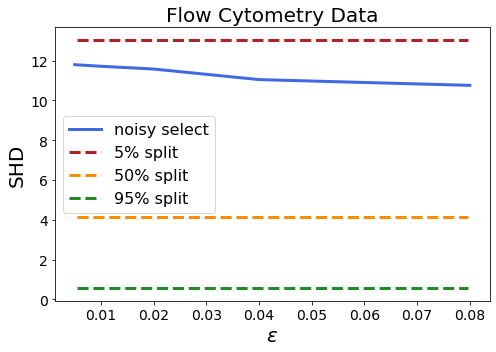

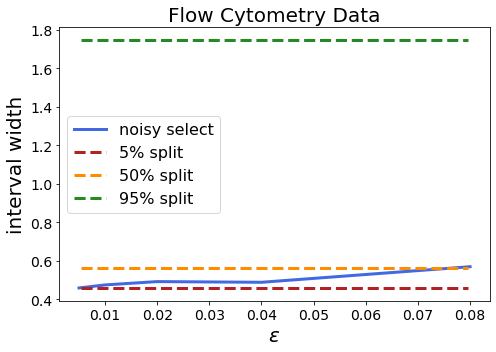

In [6]:
''' Plot the corresponding results. '''

colors=['firebrick', 'darkorange', 'forestgreen']

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_shd[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_shd[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("SHD", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=6)
plt.title("Flow Cytometry Data", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(eps_choices, [np.mean(noisy_widths[(eps, delta)]) for eps in eps_choices], \
         color='royalblue', linewidth=3, label="noisy select")
for i, split in enumerate(split_choices):
    plt.axhline(y=np.mean(split_widths[(split, delta)]), linestyle='--', xmin=0.05, xmax=0.95, \
                color=colors[i], linewidth=3, label=str(int(split*100))+'% split')
plt.xlabel("$\epsilon$", fontsize=20)
plt.ylabel("interval width", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=6)
plt.title("Flow Cytometry Data", fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
''' [EXTRA] See SHD to *true* graph for full data. '''

full_shd = []
for trial in range(trials):
    np.random.seed(trial)

    idxs = np.random.choice(range(n_full), size=n, replace=False)
    data = data_full[idxs]

    G_options = generate_graphs(G, no_graphs, p_remove, p_add)

    full_scores = [score(data, G_options[j], delta=delta) for j in range(no_graphs)]
    full_G_est = G_options[np.argmin(full_scores)]

    full_shd.append(np.sum(np.abs(G - full_G_est)))
    
print(f"The shd to the *true* graph using the full data for selection is: {np.round(np.mean(full_shd), 2)}")

The shd to the *true* graph using the full data for selection is: 7.33
